# **RNN GRU LSTM in PyTorch**

Here we use the sin wave data as in L18/3




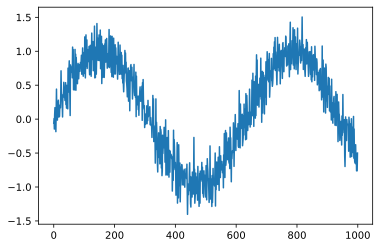

In [1]:
import torch
import torch.nn as nn
import numpy as np
import torchvision
import torchvision.datasets as datasets
from torchvision import transforms
import torch.optim as optim
import time
import torch.utils.data
# display routines
%matplotlib inline
from matplotlib import pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

embedding = 4 # embedding dimension for autoregressive model
T = 1000      # generate a total of 1000 points 
time = torch.arange(0.0,T)
x = torch.sin(0.01 * time) + 0.2 * torch.randn(T)
plt.plot(time.numpy(), x.numpy());

### Generating the Regression Dataset

In [2]:
features = torch.zeros((T-embedding, embedding))
# Use past features at window size 4 to predict 5th time series data
for i in range(embedding):
    features[:,i] = x[i:T-embedding+i]
labels = x[embedding:]


ntrain = 600
train_data = torch.utils.data.TensorDataset(features[:ntrain,:], labels[:ntrain])
test_data  = torch.utils.data.TensorDataset(features[ntrain:,:], labels[ntrain:])

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.xavier_uniform_(m.weight)
    elif classname.find('Linear') != -1:
        torch.nn.init.xavier_uniform_(m.weight)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.01)

## **Model using LSTM cell**

In [3]:
class LSTMcell(nn.Module):
    def __init__(self, input_size=1, hidden_size=100, output_size=1, 
                 num_layers = 1, batch_size = 16):
        super(LSTMcell, self).__init__()

        self.lstm = nn.LSTMCell(input_size = 4, hidden_size = hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)
        self.hidden_size = hidden_size
        self.hidden = (torch.zeros(batch_size, hidden_size), #h_0: (batch, hidden_size)
                            torch.zeros(batch_size, hidden_size)) # c_0: (batch, hidden_size)

    def forward(self, x):
        # output h_1, c_1
        lstm_out, _ = self.lstm(x)
        predictions = self.fc(lstm_out.reshape((-1, self.hidden_size)))
        return predictions

loss = nn.MSELoss()

### Training

In [4]:
# simple optimizer using adam, random shuffle and minibatch size 16
def train_net(net, data, loss, epochs, learningrate):
    trainer = optim.Adam(net.parameters(), lr = learningrate)
    data_iter = torch.utils.data.DataLoader(data, batch_size = batch_size, shuffle=True)
    for epoch in range(1, epochs + 1):
        net.train()
        for X, y in data_iter:
            trainer.zero_grad()
            # net.hidden_cell = (torch.zeros(16, 10), 
            #             torch.zeros(16, 10))
            # if not (X.shape[0] == 16):
            #     continue
            l = loss(net(X.reshape(-1, 4)), y.reshape(-1,1))
            l.backward()
            trainer.step()
        net.eval()
        l = loss(net(data[:][0]), data[:][1].reshape(-1,1))
        print('epoch %d, loss: %f' % (epoch, l.mean().item()))
    return net

batch_size = 16
net = LSTMcell(batch_size = batch_size)
print(net)
net = train_net(net, train_data, loss, 10, 0.01)

l = loss(net(test_data[:][0]), test_data[:][1].reshape(-1,1))
print('test loss: %f' % l.mean().item()) 

LSTMcell(
  (lstm): LSTMCell(4, 100)
  (fc): Linear(in_features=100, out_features=1, bias=True)
)
epoch 1, loss: 0.049585
epoch 2, loss: 0.048117
epoch 3, loss: 0.047999
epoch 4, loss: 0.048618
epoch 5, loss: 0.046784
epoch 6, loss: 0.046942
epoch 7, loss: 0.048977
epoch 8, loss: 0.048956
epoch 9, loss: 0.048067
epoch 10, loss: 0.046481
test loss: 0.053267


### Results

torch.Size([996, 4])


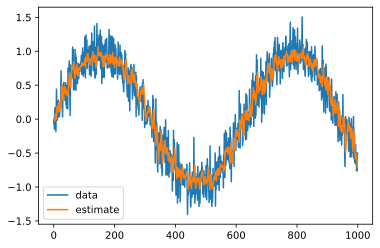

In [5]:
print(features.shape)
estimates = net(features)
plt.plot(time.numpy(), x.numpy(), label='data');
plt.plot(time[embedding:].numpy(), estimates.detach().numpy(), label='estimate');
plt.legend();

## Predictions for more than 1 step

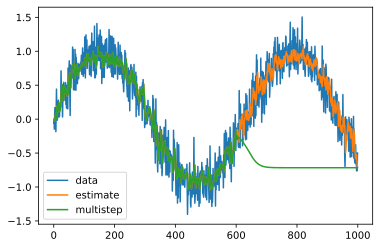

In [6]:
predictions = torch.zeros_like(estimates)
predictions[:(ntrain-embedding)] = estimates[:(ntrain-embedding)]
for i in range(ntrain-embedding, T-embedding):
    predictions[i] = net(predictions[(i-embedding):i].reshape(1,-1)).reshape(1)
    
plt.plot(time.numpy(), x.numpy(), label='data');
plt.plot(time[embedding:].numpy(), estimates.detach().numpy(), label='estimate');
plt.plot(time[embedding:].numpy(), predictions.detach().numpy(), label='multistep');
plt.legend();

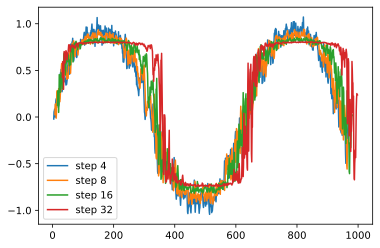

In [7]:
k = 33 # look up to k - embedding steps ahead
features = torch.zeros((T-k, k))
for i in range(embedding):
    features[:,i] = x[i:T-k+i]
for i in range(embedding, k):
    features[:,i] = net(features[:,(i-embedding):i]).reshape((-1))
for i in (4, 8, 16, 32):   
    plt.plot(time[i:T-k+i].numpy(), features[:,i].detach().numpy(), label=('step ' + str(i)))
plt.legend();

In [8]:
class LSTMcell(nn.Module):
    def __init__(self, input_size=1, hidden_size=100, output_size=1, 
                 num_layers = 1, batch_size = 16):
        super(LSTMcell, self).__init__()

        self.lstm = nn.LSTMCell(input_size = 4, hidden_size = hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)
        self.hidden_size = hidden_size
        self.hidden = (torch.zeros(batch_size, hidden_size), #h_0: (batch, hidden_size)
                            torch.zeros(batch_size, hidden_size)) # c_0: (batch, hidden_size)

    def forward(self, x):
        # output h_1, c_1
        lstm_out, _ = self.lstm(x)
        predictions = self.fc(lstm_out.reshape((-1, self.hidden_size)))
        return predictions

loss = nn.MSELoss()

## **Model using LSTM function**

Compared to LSTMcell, LSTM are optimized with cuDNN.

In [9]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=100, output_size=1, 
                 num_layers = 1, batch_size = 16):
        super(LSTM, self).__init__()

        self.lstm = nn.LSTM(input_size = 4, hidden_size = hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)
        self.hidden_size = hidden_size
        # h_0: (num_layers * num_directions, batch, hidden_size)
        # c_0: (num_layers * num_directions, batch, hidden_size)
        self.hidden = (torch.zeros(1, batch_size, hidden_size), 
                            torch.zeros(1, batch_size, hidden_size)) 

    def forward(self, x):
        # output h_1, c_1
        # print(x.shape)
        lstm_out, _ = self.lstm(x, self.hidden)
        predictions = self.fc(lstm_out.reshape((-1, self.hidden_size)))
        return predictions

loss = nn.MSELoss()

# simple optimizer using adam, random shuffle and minibatch size 16
def train_net(net, data, loss, epochs, learningrate):
    trainer = optim.Adam(net.parameters(), lr = learningrate)
    data_iter = torch.utils.data.DataLoader(data, batch_size = batch_size, shuffle=True)
    for epoch in range(1, epochs + 1):
        net.train()
        for X, y in data_iter:
            trainer.zero_grad()
            # net.hidden_cell = (torch.zeros(16, 10), 
            #             torch.zeros(16, 10))
            # if not (X.shape[0] == 16):
            #     continue
            X = X.reshape(1, -1, 4)
            if not X.shape[1] == batch_size:
                continue
            l = loss(net(X), y.reshape(-1,1))
            l.backward()
            trainer.step()
        net.eval()
        train_l = 0
        iters = 0
        for X, y in data_iter:
            X = X.reshape(1, -1, 4)
            if not X.shape[1] == batch_size:
                continue
            train_l += loss(net(X), y.reshape(-1,1)).mean().item()
            iters += 1
        print('epoch %d, loss: %f' % (epoch, train_l/iters))
    return net

batch_size = 16
net = LSTM(batch_size = batch_size)
print(net)
net = train_net(net, train_data, loss, 10, 0.01)

test_l = 0
iters = 0
test_data_iter = torch.utils.data.DataLoader(test_data, batch_size = batch_size, shuffle=True)
for X, y in test_data_iter:
    X = X.reshape(1, -1, 4)
    if not X.shape[1] == batch_size:
        continue
    test_l += loss(net(X), y.reshape(-1,1)).mean().item()
    iters += 1
print('test loss: {}'.format(test_l/iters))

LSTM(
  (lstm): LSTM(4, 100)
  (fc): Linear(in_features=100, out_features=1, bias=True)
)
epoch 1, loss: 0.053238
epoch 2, loss: 0.050247
epoch 3, loss: 0.048671
epoch 4, loss: 0.051499
epoch 5, loss: 0.046360
epoch 6, loss: 0.047126
epoch 7, loss: 0.046685
epoch 8, loss: 0.050043
epoch 9, loss: 0.047493
epoch 10, loss: 0.049616
test loss: 0.05901197794203957
